# Calculating the volume of a flood
This notebook aims to identify single floods from a hydrograph (eg take each peak of a hydrograph above a certain level) and generate an image of what each flood looked like. It also aims to tell you how many cumecs went through the gauge for the whole flood (like a cummulative sum for the whole peak)

First of all, here's the imports I usually use for all my notebooks, but includes the scipy.signal import for the part where it identifies where a peak starts and finishes. It accesses the Scripts folder and a back-end python file that gets data from a cahce of Water Data Online then puts them against a map

In [2]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal

from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('Scripts')
import dea_bom

dc = datacube.Datacube(app='Inundation_mapping')

stations_pkl = Path('Scripts/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('Scripts/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]

Loading from cache
4305 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

## Get the map with the gauges on it

In [4]:
gauge_data, station = dea_bom.ui_select_station(stations)

## Choose a threshold for the hydrograph and see where the clear passes are

You have this many clear passes passes:160
Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.


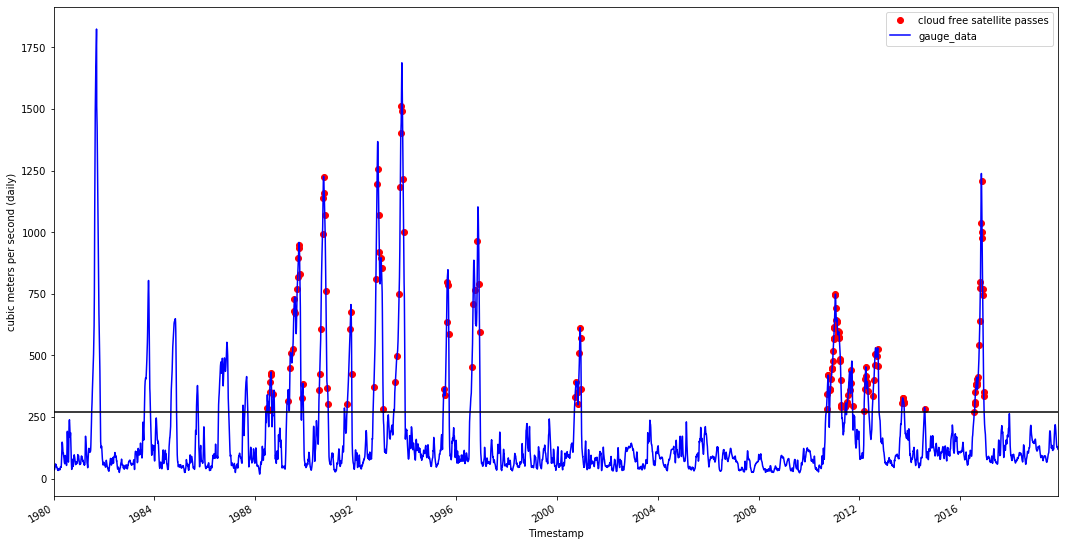

In [6]:
#set threshold for flow rate
yaxis_lower_parameter = 270


# The lat and lon takes the location of the gauge. You can change the lat 
# and lon to a different location if necessary, just comment out out this 
# lat, lon = pos line below and define your own.
lat, lon = station.pos

# lat =
# lon =

# The buffer is how many meters radius around the location you want to display.
buffer = 10000

lat, lon

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

#convert Pandas dataframe to xArray for merging with WOfS
gauge_data_xr = gauge_data.to_xarray() 

#this is the xArray merge function
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) 

#Now define the passes to load based on user input
specified_satellite_passes = merged_data.where((merged_data.Value > yaxis_lower_parameter), drop=True)
specified_satellite_passes = specified_satellite_passes.drop('Timestamp')

date_list = specified_satellite_passes.time.values


# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Cloud mask
cc = masking.make_mask(specified_passes.water, cloud=True)
npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice
ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)
clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.3)

#Now take the clear passes and make a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_specified_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called time
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')


#Plot the clear satellite passes over the hydrograph
ax = clear_merged_data.plot(marker = 'o', color='red', linestyle='None', figsize=(18,10))
plt.ylabel('cubic meters per second (daily)')
gauge_data.plot(ax=ax, color='blue')
plt.axhline(yaxis_lower_parameter, color='black') #putting a black line to show the chosen threshold
ax.legend(["cloud free satellite passes", "gauge_data"]);

#Check how many passes you are about to load. I recommend loading 100 to 400 passes.
print("You have this many clear passes passes:{}".format(clear_specified_passes.time.shape[0]))

print("Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.")

## Now we want to identify where a peak starts and ends
This code was taken from a notebook called peak_picking.ipynb that Kirill and I wrote in like August 2019. That notebook is not on github, it is in my home directory on my sandbox so if you want the peak_picking notebook, let me know. As you can see, the peaks can be kind of messy, like they go up and down so much that it ends up being pretty noisy no matter which threshold you pick.

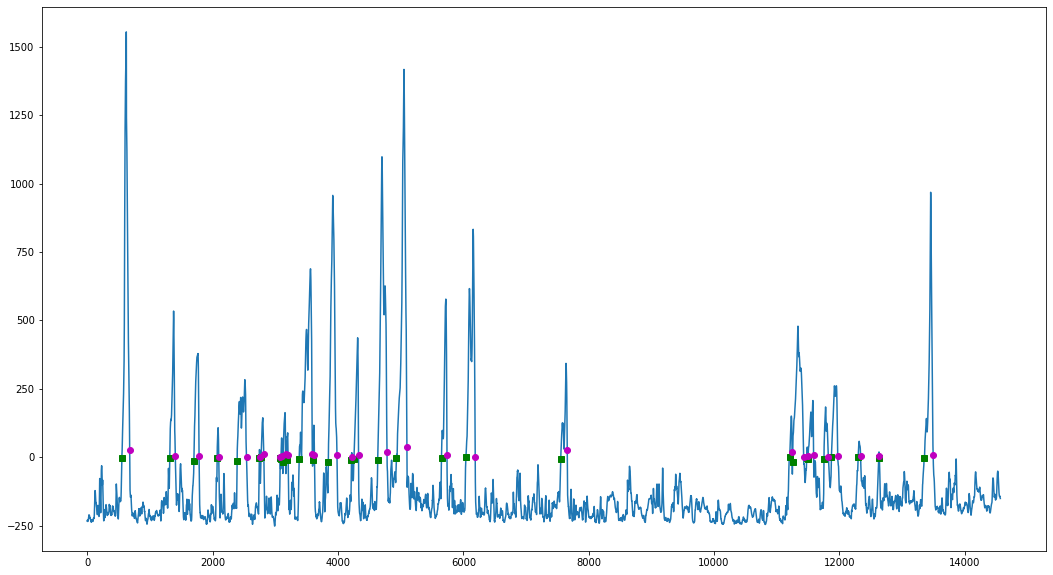

In [13]:


xx = gauge_data.values.ravel() - yaxis_lower_parameter
hi = xx > 0
lo = xx <= 0
crosses_up = lo[:-1] * hi[1:] 
crosses_lo = hi[:-1]*lo[1:]

crosses_up = np.hstack([crosses_up, np.r_[False]])
crosses_lo = np.hstack([crosses_lo, np.r_[False]])

ii = np.arange(0, xx.shape[0])
fig, ax = plt.subplots(1, figsize=(18,10))
ax.plot(ii, xx, '-', 
        ii[crosses_up], xx[crosses_up] , 'gs',
        ii[crosses_lo], xx[crosses_lo] , 'mo');


#green squares are called crosses_up
#purple circles are called crosses_lo
#Red squares are called pp
#Hydrograph data (blue line) is called gauge_data

## Make a dictionary of dates for each peak
I don't know how to do this.. 